In [362]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print('tensorflow', tf.__version__)

tensorflow 2.12.0


In [363]:
# Load and preprocess the image data
image_paths = glob.glob('./Al_data/images/*.*')
image_data = []
for path in image_paths:
    img = Image.open(path)
    img = img.resize((28, 28))  # Resize image to desired dimensions
    img = (np.array(img) - 127.5) / 127.5  # Normalize pixel values to [-1, 1]
    image_data.append(img)

image_data = np.array(image_data)


In [364]:
image_data.shape

(69, 28, 28, 3)

In [365]:
image_data = image_data[:, :, :, 0:1]
image_data = image_data.astype('float32')
image_data.shape

(69, 28, 28, 1)

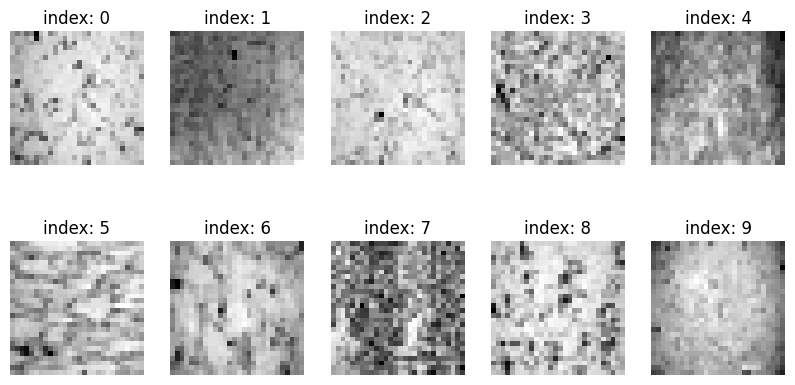

In [366]:
plt.figure(figsize=(10,5))

for i in range(10):
    plt.subplot(2,5, i+1)
    plt.imshow(image_data[i].reshape(28,28), cmap= 'gray')
    plt.title(f'index: {i}')
    plt.axis('off')
    
plt.show()

In [367]:
BUFFER_SIZE = 60000
BATCH_SIZE = 32

In [368]:
train_dataset = tf.data.Dataset.from_tensor_slices(image_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

In [369]:
def make_generator_model():
    
    #Start
    model = tf.keras.Sequential()
    
    #First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias =False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Second: Reshape layer
    model.add(layers.Reshape((7,7,256)))
    
    #Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5,5), strides= (1,1),padding = 'same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    #Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5,5), strides= (2,2),padding = 'same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    #Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5,5), strides= (2,2),padding = 'same', use_bias=False, activation = 'tanh'))
    
    return model

In [370]:
generator = make_generator_model()

generator.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_36 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_60 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_12 (Reshape)        (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_36 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_37 (Bat  (None, 7, 7, 128)      

In [371]:
noise = tf.random.normal([1,100])
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.0125051 ,  0.8525285 , -1.7655734 ,  0.04423802, -0.9160494 ,
        -0.4108096 , -0.5551913 , -2.6525261 , -0.55683434, -0.96107894,
        -0.28269684,  0.9144024 ,  0.24419044,  0.4612499 ,  1.1104656 ,
        -1.3405588 , -0.41696617, -0.00626882,  0.73968446, -0.3644274 ,
         0.06297315, -0.29056108,  0.418012  , -1.8700802 ,  0.6952387 ,
         0.13504581, -0.65657717,  0.13089727, -1.205447  , -0.32503912,
         2.056074  , -1.9565935 ,  0.496139  , -0.7906085 , -0.50030446,
        -0.33831865,  1.5539118 ,  0.2629129 , -0.20270362, -0.54858935,
         1.0953723 , -0.18095516, -0.00626748, -0.23938976, -0.30102494,
        -1.5057662 , -0.05195066, -1.0813247 ,  1.5159757 , -0.6192948 ,
        -1.4262439 ,  0.24400766, -0.02619703,  0.22133513, -0.4766656 ,
         0.45946443,  0.45026383, -0.09609956,  0.5858368 ,  1.2658616 ,
        -0.0255816 , -0.68636835,  0.76840544,  0.05089906,  0.47887045,
 

In [372]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

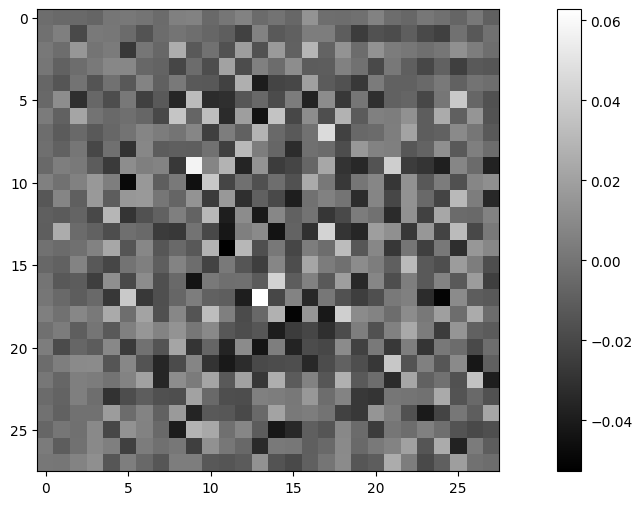

In [373]:
plt.imshow(generated_image[0,:,:,0], cmap= 'gray')
plt.colorbar()
plt.show()

In [374]:
##판별자 구현하기

def make_discriminator_model():
    
        #Start
    model = tf.keras.Sequential()
    
    #First: Conv2D layer
    model.add(layers.Conv2D(64, (5,5), strides= (2,2), padding = 'same', input_shape=[28,28,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #Second: Conv2D layer
    model.add(layers.Conv2D(128, (5,5), strides= (2,2), padding = 'same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    #Third: Flatten layer
    model.add(layers.Flatten())
    
    #Fourth: Dense layer
    model.add(layers.Dense(1))

    return model

In [375]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_63 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_24 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_64 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_25 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_12 (Flatten)        (None, 6272)            

In [377]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits= True)

In [378]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    
    return total_loss

In [379]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    
    return real_accuracy, fake_accuracy

In [380]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [381]:
noise_dim = 100
num_examples_to_generate= 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [382]:
@tf.function
def train_step(images): #(1)입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) #(2) 생성자 입력 노이즈
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape: #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training = True) #(4) generated_image 생성
        
        #(5) discriminator 판별
        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)
        
        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy 
    

In [383]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training= False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0], cmap = 'gray')
        plt.axis('off')
        
    plt.savefig('./Al_data/generated_sample/sample_epoch_{:04d}_iter_{:03d}.png'.format(epoch, it))
    
    plt.show()

In [384]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6


def draw_train_history(history, epoch):
    #summarize history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc = 'upper left')
    
    #summarize history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuray')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc = 'upper left')
    
    #plt.savefig()
    
    plt.savefig('./Al_data/history/train_history_{:04d}.png'.format(epoch))
    
    plt.show()

In [385]:
checkpoint_dir = './Al_data/training_checkpoints/'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [386]:
#학습
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50== 0:
                display.clear_output(wait =True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {}'.format(epoch+1, int(time.time()-epoch_start)))
                
        if (epoch +1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))
        
        draw_train_history(history, epoch)

In [387]:
save_every = 5
EPOCHS = 50

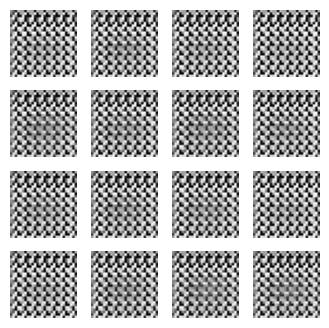

Time for training : 104 sec


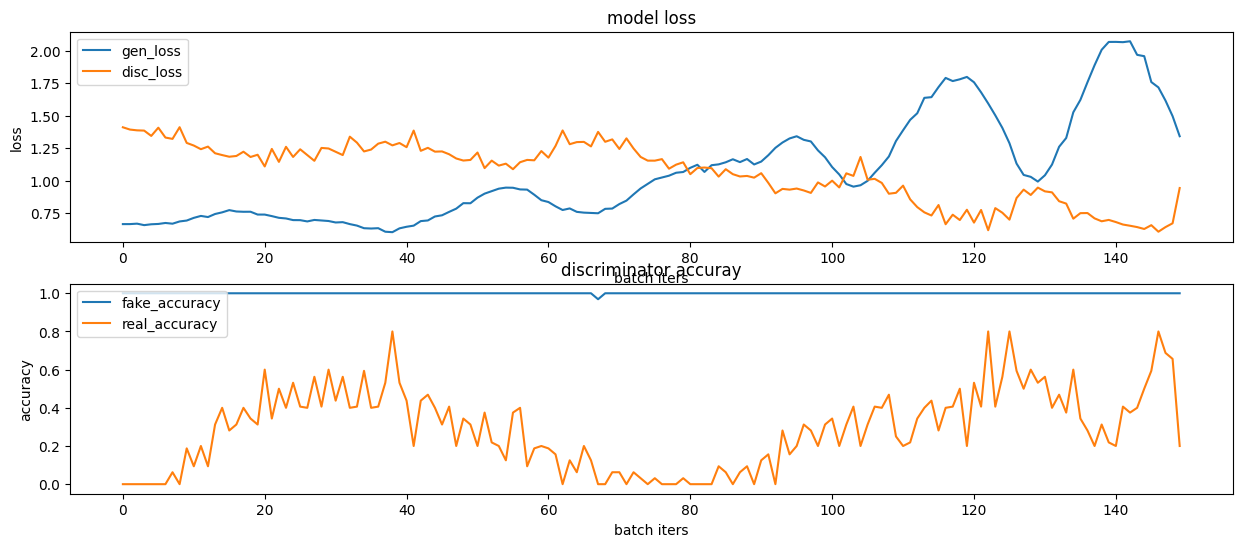

CPU times: total: 1min 5s
Wall time: 1min 44s


In [388]:
%%time
train(train_dataset, EPOCHS, save_every)